# ECE 209AS Lab 2: RRT-Based Planner

## Imports

In [1]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from shapely.geometry import Polygon, Point, LineString
from shapely.ops import cascaded_union, unary_union
from tqdm import tqdm_notebook
import os, os.path
import imageio
import time
from copy import copy, deepcopy

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display

# Setting seed for reproduceable results
random.seed( 31 )

## Classes

In [2]:
class SystemModel:
    def __init__(self, state, wheel_radius, robot_width, tail_length):
        # all parameters are in mm
        self.state = state
        self.wheel_radius = wheel_radius
        self.robot_width = robot_width
        self.tail_length = tail_length
    
    # Getters/Setters
    def getState(self):
        return self.state
    def getWheelRadius(self):
        return self.wheel_radius
    def getRobotWidth(self):
        return self.robot_width
    def getTailLength(self):
        return self.tail_length

In [3]:
class State: # (x,y) point and angle theta
    def __init__(self, x, y, theta):
        self.x = x
        self.y = y
        self.theta = theta
        
    # Getters/Setters
    def getX(self):
        return self.x
    def getY(self):
        return self.y
    def getTheta(self): # in degrees
        return self.theta
    
    # Transformations
    def toTuple(self):
        return (self.x, self.y, self.theta)
    def rotateCorners(self, four_corners):
        four_corners_rotated = np.dot(getRotationMat(self.theta-90), four_corners)
        four_corners_rotated = four_corners_rotated + np.array([[self.x],[self.y]])
        rect = Polygon(four_corners_rotated.T)
        return rect
    def toShapely(self, lw=0):
        four_corners = np.array([[-(45-lw),(45-lw), (45-lw),-(45-lw)],[-(75-lw),-(75-lw),(25-lw),(25-lw)]])
        return self.rotateCorners(four_corners)
    def toPlot(self, high_def=True, scheme=None):
        lw = 0
        if scheme is not None and len(scheme) > 1:
            lw = scheme[1]
        lw = lw / 2
                
        return_arr = [self.toShapely(lw=lw).exterior.xy]
        if high_def:
            # return a robot with a couple of extra features (wheels plus pivot)
            
            # left wheel
            left_wheel_corners = np.array([[-(40-lw),-(35-lw), -(35-lw),-(40-lw)],[-(25-lw),-(25-lw), (25-lw),(25-lw)]])
            left_wheel_rect = self.rotateCorners(left_wheel_corners)
            return_arr.append(left_wheel_rect.exterior.xy)
            
            # right wheel
            right_wheel_corners = np.array([[(35-lw),(40-lw), (40-lw),(35-lw)],[-(25-lw),-(25-lw), (25-lw),(25-lw)]])
            right_wheel_rect = self.rotateCorners(right_wheel_corners)
            return_arr.append(right_wheel_rect.exterior.xy)
            
            # pivot
            pivot_corners = np.array([[-(lw),(lw), (lw),-(lw)],[-(lw),-(lw), (lw),(lw)]])
            pivot_rect = self.rotateCorners(pivot_corners)
            return_arr.append(pivot_rect.exterior.xy)
        return return_arr
    
    def toPoint(self, scheme=None):
        rad = 3
        if scheme is not None and len(scheme) > 3:
            rad = scheme[3]
            
        circle = Point(self.getX(), self.getY()).buffer(rad)
        return [circle.exterior.xy]
    
    # Costs
    def setCost(self, cost):
        self.cost = cost
    def getCost(self):
        return self.cost

In [4]:
class Action:
    def __init__(self, wl, wr, t):
        self.wl = wl
        self.wr = wr
        self.t = t
        
    # Getters/Setters
    def getWl(self):
        return self.wl
    def getWr(self):
        return self.wr
    def getT(self):
        return self.t
    
    # Helper Functions
    def getDistance(self):
        return 0
    def toTuple(self):
        return (self.wl, self.wr, self.t)
    
class ControlInput:
    def __init__(self, actions):
        # actions = (R1, D, R2) where R1/R2 are rotation Actions and D is drive Action
        assert(len(actions) == 3)
        if not (round(sum([a.getT() for a in actions]),7) == 1):
            print("Expected ControlInput sum of 1, got ", sum([a.getT() for a in actions]))
            print([action.toTuple() for action in actions])
        self.actions = actions
    def getActions(self):
        return self.actions
    
    # Helper Functions
    def getDistance(self):
        return sum([a.getDistance() for a in actions])
    def prettyPrint(self):
        for action in self.getActions():
            print(action.toTuple())

In [5]:
class StateSpace:
    def __init__(self, W, H):
        self.W = W
        self.H = H
    
    # Getters/Setters
    def getW(self):
        return self.W
    def getH(self):
        return self.H
    
    # Helper Functions
    def toShapely(self, border=0):
        return Polygon([(-border, -border), (self.W+border, -border), (self.W+border, self.H+border), (-border, self.H+border)])
    
    def toObstacles(self, width=1):
        edge1 = Obstacle(0,0,self.W, -width)
        edge2 = Obstacle(0,0,-width, self.H)
        edge3 = Obstacle(self.W, self.H, width, -self.H)
        edge4 = Obstacle(0, self.H, self.W, width)
        return [edge1, edge2, edge3, edge4]
    
class Obstacle:
    def __init__(self, x, y, W, H):
        self.x = x
        self.y = y
        self.W = W
        self.H = H
        
    # Getters/Setters
    def getW(self):
        return self.W
    def getH(self):
        return self.H
    def getX(self):
        return self.x
    def getY(self):
        return self.y
    
    # Helper Functions
    def toShapely(self, lw=0):
        return Polygon([(self.x+lw, self.y+lw), (self.x + self.W-lw, self.y+lw), 
                        (self.x + self.W-lw, self.y + self.H-lw), (self.x+lw, self.y + self.H-lw)])

# General Rotation Matrix
def getRotationMat(theta):
    rotation_mat = np.array([[np.cos(math.pi*theta/180), -np.sin(math.pi*theta/180)],[np.sin(math.pi*theta/180), np.cos(math.pi*theta/180)]])
    return rotation_mat

# Define the operational Space
class OperationalSpace:
    def __init__(self, obstacles):
        # obstacles = list of Obstacle objects (rectangles)
        self.obstacles = obstacles
        
    def getObstacles(self):
        return self.obstacles
    
    def drawPie(self, corner1, corner2, center):
        # Define the arc - assumes two (x,y) corner points
        centerx, centery = center
        corner1x, corner1y = corner1
        corner2x, corner2y = corner2
        
        radius = np.linalg.norm(corner1)
        if abs(radius - np.linalg.norm(corner2)) > 10**-5:
            raise Exception(radius, np.linalg.norm(corner2))
        
        start_angle = math.atan2(corner1y, corner1x)*180/math.pi
        end_angle = math.atan2(corner2y, corner2x)*180/math.pi
        
        # covert angles to their respective degrees from x-axis
        start_angle = start_angle if start_angle > 0 else 360 + start_angle
        end_angle = end_angle if end_angle > 0 else 360 + end_angle
        
        # if end_angle is larger than start_angle, switch them:
        if end_angle > start_angle:
            temp = copy(start_angle)
            start_angle = end_angle
            end_angle = temp
            
        if start_angle - end_angle > 180:
            end_angle += 360
        
        numsegments = 1000

        # The coordinates of the arc
        theta = np.radians(np.linspace(start_angle, end_angle, numsegments))
        x = centerx + radius * np.cos(theta)
        y = centery + radius * np.sin(theta)
        
        # append center point to make it a pie
        x = np.concatenate((x, [centerx]))
        y = np.concatenate((y, [centery]))
        
        pie = Polygon(np.column_stack([x, y]))
        return pie
    
    def rotateCollider(self, x, prerotation, rotation_angle, as_union=True):
        # get the two four-corner sets pre- and post-rotation
        four_corners = np.array([[-45,45, 45,-45],[-75,-75,25,25]])
        four_corners_pre = np.dot(getRotationMat(prerotation), four_corners)
        
        # rotate the robot again by x.getTheta()
        four_corners_post = np.dot(getRotationMat(rotation_angle), four_corners_pre)
        
        # draw pie between each set of matching corners:
        pie1 = self.drawPie(four_corners_pre[:, 0], four_corners_post[:, 0], (x.getX(), x.getY()))
        pie2 = self.drawPie(four_corners_pre[:, 1], four_corners_post[:, 1], (x.getX(), x.getY()))
        pie3 = self.drawPie(four_corners_pre[:, 2], four_corners_post[:, 2], (x.getX(), x.getY()))
        pie4 = self.drawPie(four_corners_pre[:, 3], four_corners_post[:, 3], (x.getX(), x.getY()))
        
        # make polygons out of the corners
        rect1 = Polygon(np.add(four_corners_pre, [[x.getX(), x.getX(), x.getX(), x.getX()],
                                                  [x.getY(), x.getY(), x.getY(), x.getY()]]).T)
        rect2 = Polygon(np.add(four_corners_post, [[x.getX(), x.getX(), x.getX(), x.getX()],
                                                   [x.getY(), x.getY(), x.getY(), x.getY()]]).T)
        
        # union the two rects with these pie slices to get the final result:
        collider = [pie1, pie2, pie3, pie4, rect1, rect2]
        if as_union:
            # if collider has a self-intersecting shape, we cannot perform unary_union:
            bad_shape = False
            bad_region = False
            for shape in collider:
                if not shape.is_valid:
                    bad_shape = True
                    break
            if not bad_shape:
                try:
                    regions = unary_union(collider)
                except:
                    # if the resulting union has a hole in it, we can't union them all at once
                    bad_region = True
            if (bad_shape and not bad_region) or bad_region:
                regions = None
                for r in range(len(collider)):
                    if r == 0:
                        regions = collider[r]
                    else:
                        regions = regions.union(collider[r])
            return regions
        
        return collider
    
    # Determine if the path is collision free
    def isCollision(self, trajectory, xi, xt, basic=False, as_union=True, verbose=False):
        actions = trajectory.getActions()

        # Calculate the distances travelled in each step of the robot's movement
        distance_per_rotation = 2 * math.pi * s.getWheelRadius()
        distance_per_minute = distance_per_rotation * actions[1].getWl()
        distance_per_second = distance_per_minute / 60
        distance_traveled = distance_per_second * actions[1].getT()
        
        # calc R1 rotation angle (used for rect as well as circle1/colliders_R1)
        distance_per_second_R1 = distance_per_rotation*(actions[0].getWr()/60)
        rotation_angle_R1 = 360*distance_per_second_R1 * actions[0].getT() / (math.pi * s.getRobotWidth())
        if (rotation_angle_R1 > 180):
            rotation_angle_R1 = 360 - rotation_angle_R1
        elif (rotation_angle_R1 < -180):
            rotation_angle_R1 = 360 + rotation_angle_R1
        
        # Create the rectangle that represents the robot's drive motion
        actual_angle = xi.getTheta() + rotation_angle_R1 - 90
        four_corners = np.array([[-45,45, 45,-45],[-75,-75,25+distance_traveled,25+distance_traveled]])
        four_corners_rotated = np.dot(getRotationMat(actual_angle), four_corners)
        four_corners_rotated = four_corners_rotated + np.array([[xi.getX()],[xi.getY()]])
        rect = Polygon(four_corners_rotated.T)
        shapes_to_union = [rect]
        
        if basic:
            # Using simple circles
            if (actions[0].getT() > 10**-10 and abs(actions[0].getWr()) > 10**-10):
                circle1 = Point(xi.getX(), xi.getY()).buffer(7650**.5)
                shapes_to_union.append(circle1)
            if (actions[2].getT() > 10**-10 and abs(actions[2].getWr()) > 10**-10):
                circle2 = Point(xt.getX(), xt.getY()).buffer(7650**.5) # use only if R2 is for >0 seconds
                shapes_to_union.append(circle2)
        else:
            # Adding high-poly colliders
            if (actions[0].getT() > 10**-10 and abs(actions[0].getWr()) > 10**-10):
                colliders_R1 = self.rotateCollider(xi, xi.getTheta() - 90, rotation_angle_R1, as_union=as_union)
                if colliders_R1 is not None:
                    if as_union:
                        shapes_to_union.append(colliders_R1)
                    else:
                        shapes_to_union += colliders_R1
                else:
                    # return that there is a collision if we can't make the collider shapes
                    return True
            if (actions[2].getT() > 10**-10 and abs(actions[2].getWr()) > 10**-10):
                # calc R2 rotation angle
                distance_per_second_R2 = distance_per_rotation*(actions[2].getWr()/60)
                rotation_angle_R2 = 360*distance_per_second_R2 * actions[2].getT() / (math.pi * s.getRobotWidth())

                colliders_R2 = self.rotateCollider(xt, actual_angle, rotation_angle_R2, as_union=as_union)
                if colliders_R2 is not None:
                    if as_union:
                        shapes_to_union.append(colliders_R2)
                    else:
                        shapes_to_union += colliders_R2
                else:
                    # return that there is a collision if we can't make the collider shapes
                    return True
        
        # if collider has a self-intersecting shape, we cannot perform unary_union:
        bad_shape = False
        bad_region = False
        for shape in shapes_to_union:
            if not shape.is_valid:
                bad_shape = True
                break
        if not bad_shape:
            try:
                regions = unary_union(shapes_to_union)
            except:
                # if the resulting union has a hole in it, we can't union them all at once
                bad_region = True
        if (bad_shape and not bad_region) or bad_region:
            regions = None
            for r in range(len(shapes_to_union)):
                if r == 0:
                    regions = shapes_to_union[r]
                else:
                    regions = regions.union(shapes_to_union[r])
        
        is_collision = False
        for obstacle in self.obstacles:
            obstacle_rect = obstacle.toShapely()
            if (verbose):
                plt.figure(figsize=(10,10))
                for shape in shapes_to_union:
                    plt.plot(*shape.exterior.xy);
                plt.plot(*obstacle_rect.exterior.xy);
                plt.show()
            if (regions.intersects(obstacle_rect) or regions.contains(obstacle_rect)):
                is_collision = True
                break
        return is_collision
    
    def isObstacle(self, x):
        shapes_to_union = [obstacle.toShapely() for obstacle in self.obstacles]
        regions = unary_union(shapes_to_union)
        
        return regions.intersects(x.toShapely())

#### Plotting classes

In [6]:
# Global schemes: use the following different color schemes to suit different purposes
# - format: {name: [edge color, line with, face color, optional: radius for points]}
#                                          ^ if not None, then we fill the object

# generic block-style drawings
flat_land = {
    'background': ['w', 0, 'w'],
    'obstacles': ['darkred', 2, 'red'],
    'bounds': ['black', 2, None],
    'robot_init': ['blue', 3, 'lightblue'],
    'robot_moved': ['orangered', 3, 'lightsalmon'],
    'goal': ['chocolate', 2, 'gold'],
    'point_init': ['blue', 2, None, 3],
    'point_moved': ['orangered', 2, None, 3],
    'point_goal': ['chocolate', 2, None, 3],
    'edge': ['lightsalmon', 2, None],
    'edge_goal': ['gold', 2, None]
}

# made to look like a parking lot
parking_lot = {
    'background': ['gray', 0, 'gray'],
    'obstacles': ['white', 1, 'ivory'],
    'bounds': ['ivory', 2, None],
    'robot_init': ['blue', 3, 'lightblue'],
    'robot_moved': ['orangered', 3, 'lightsalmon'],
    'goal': ['green', 2, 'ivory'],
    'point_init': ['blue', 2, None, 3],
    'point_moved': ['orangered', 2, None, 3],
    'point_goal': ['green', 2, None, 3],
    'edge': ['lightsalmon', 2, None],
    'edge_goal': ['ivory', 2, None]
}

In [7]:
class Plotter:
    # Color Scheme format: {name: [color, [edge color, line width (only used if fill)]], ...}
    color_scheme = None
    state_space = None
    goal_space = None
    obstacle_space = None
    high_def = None
    obstacle_lim = None
    
    def __init__(self, state_space, goal_space, color_scheme=None, obstacle_space=None, high_def=False, obstacle_lim=4):
        self.state_space = state_space
        self.goal_space = goal_space
        self.high_def = high_def
        if obstacle_space is not None:
            self.obstacle_space = obstacle_space
        if color_scheme is not None:
            self.color_scheme = color_scheme
        else:
            self.color_scheme = flat_land
        self.obstacle_lim = obstacle_lim
            
    @staticmethod
    def plot_object(point_set, scheme, scalex=True, scaley=True):
        if type(point_set) is not list:
            point_set = [point_set]
        for points in point_set:
            if scheme[2] is not None: # if filled
                plt.fill(*points, edgecolor=scheme[0], linewidth=scheme[1], facecolor=scheme[2])
            else:
                plt.plot(*points, color=scheme[0], linewidth=scheme[1])
            
    def initialize_figure(self, xi, title=None):
        plt.figure(figsize=(10, 10), dpi=80)
        
        if title is not None:
            plt.title(title)
            
        # Plot background
        self.plot_object(self.state_space.toShapely(border=50).exterior.xy, self.color_scheme['background'],
                         scalex=False, scaley=False)
            
        # Plot robot
        if xi is not None:
            self.plot_object(xi.toPlot(high_def=self.high_def, scheme=self.color_scheme['robot_init']), 
                             self.color_scheme['robot_init'])

        # Plot goal space
        self.plot_object(Polygon(np.array(self.goal_space[0:2]).T).exterior.xy, self.color_scheme['goal'])

        # Plot obstacles
        if self.obstacle_space is not None:
            for i, obstacle in enumerate(self.obstacle_space.getObstacles()):
                if i >= self.obstacle_lim:
                    break
                self.plot_object(obstacle.toShapely(lw=self.color_scheme['obstacles'][1]).exterior.xy, 
                                 self.color_scheme['obstacles'])

        # Plot state space
        self.plot_object(self.state_space.toShapely(border=self.color_scheme['bounds'][1]).exterior.xy, 
                         self.color_scheme['bounds'])

    def plot_trajectory(self, xi, trajectory, title=None, saveto=None):
        self.initialize_figure(xi, title)
        for v in trajectory:
            assert type(v) is State
            self.plot_object(v.toPlot(high_def=self.high_def, scheme=self.color_scheme['robot_moved']), 
                             self.color_scheme['robot_moved'])
        if saveto is not None:
            plt.savefig(saveto + ".jpg")
            plt.close()
        else:
            plt.show()
            
    def plot_state(self, x_next, title=None, saveto=None):
        self.initialize_figure(xi=None, title=title)
        self.plot_object(x_next.toPlot(high_def=self.high_def, scheme=self.color_scheme['robot_moved']), 
                         self.color_scheme['robot_moved'])
        if saveto is not None:
            plt.savefig(saveto + ".jpg")
            plt.close()
        else:
            plt.show()
            
    def plot_edges(self, edges, is_last=False, goal_vert=None, title=None, saveto=None):
        self.initialize_figure(xi=None, title=title)
        
        # check whether the goal_vert is in the list of edges
        goal_edge_idx = -1
        if goal_vert is not None:
            for e_idx, e in enumerate(edges):
                if e[1].toTuple() == goal_vert.toTuple():
                    goal_edge_idx = e_idx
                    break
        
        # if at the last iteration, plot the chosen trajectory in a different color
        if goal_edge_idx > -1 or is_last:
            # find all vertices/edges that lead to start:
            chosen_edges = [(goal_edge_idx if goal_edge_idx > -1 else len(edges) - 1)]    # list of chosen edge indices
            current_state = edges[goal_edge_idx][0]
            while current_state.toTuple() != edges[0][0].toTuple():
                parent_edges = [x_ for x_ in enumerate(edges) if x_[1][1].toTuple() == current_state.toTuple()]
                assert len(parent_edges) == 1
                chosen_edges.append(parent_edges[0][0])
                current_state = parent_edges[0][1][0]
            assert len(chosen_edges) > 0
            
            # plot all of the connecting edges first:
            for i, edge in enumerate(edges):
                x1 = edge[0].toTuple()
                x2 = edge[1].toTuple()
                self.plot_object(LineString([(x1[0], x2[0]), (x1[1], x2[1])]).coords, self.color_scheme['edge' if i not in chosen_edges
                                                                                                        else 'edge_goal'])

            # plot all of the vertices next:
            for i, edge in enumerate(edges):
                # plot the first point in every edge and plot the very first point too:
                if i == 0:
                    self.plot_object(edge[0].toPoint(self.color_scheme['point_init']), self.color_scheme['point_init'])
                self.plot_object(edge[1].toPoint(), self.color_scheme['point_goal' if i in chosen_edges
                                                                      else 'point_moved'])
        else:
            # plot all of the connecting edges first:
            for i, edge in enumerate(edges):
                x1 = edge[0].toTuple()
                x2 = edge[1].toTuple()
                self.plot_object(LineString([(x1[0], x2[0]), (x1[1], x2[1])]).coords, self.color_scheme['edge'])
               
            # plot all of the vertices next:
            for i, edge in enumerate(edges):
                # plot the first point in every edge and plot the very first point too:
                if i == 0:
                    self.plot_object(edge[0].toPoint(self.color_scheme['point_init']), self.color_scheme['point_init'])
                self.plot_object(edge[1].toPoint(), self.color_scheme['point_moved'])
            
        if saveto is not None:
            plt.savefig(saveto + ".jpg")
            plt.close()
        else:
            plt.show()

In [8]:
class Animator:
    trajectory = None
    fpt = None                    # How many frames to dedicate per each state transition
    control_inputs = []           # 1 control input per time step
    init_state = None
    next_states = []              # 1 end state per time step
    states_per_frame = []         # 1 state per frame
    output_path = None
    
    def __init__(self, trajectory, frames_per_transistion=10, obstacle_lim=None):
        self.trajectory = trajectory
        self.fpt = frames_per_transistion
        self.init_state = trajectory[0]
        self.next_states = trajectory[1:]
        self.obstacle_lim = obstacle_lim
        assert self.fpt <= 100    # 0.01 increments are the smallest GIF files can handle
        
    def gatherControllerInputs(self):
        self.control_inputs = []
        curr_state = self.init_state
        for next_state in self.next_states:
            self.control_inputs.append(getTrajectory(curr_state, next_state))
            curr_state = next_state
            
    def gatherIntermediateStates(self):
        intermediate_states = [self.init_state]
        
        # gather [fpt number of] intermediate states per control input
        for c_idx, control_input in enumerate(self.control_inputs):
            # perform a simulation to get from xi -> next_state using control_input:
            R1, D, R2 = control_input.getActions()
            total_time = R1.getT() + D.getT() + R2.getT()

            frames_for_R1 = 0
            frames_for_D = 0
            frames_for_R2 = 0

            if R1.getT() > 10**-10:
                frames_for_R1 = max(round(R1.getT() / total_time * self.fpt), 1)
            if D.getT() > 10**-10:
                frames_for_D = max(round(D.getT() / total_time * self.fpt), 1)
            if R2.getT() > 10**-10:
                frames_for_R2 = max(round(R2.getT() / total_time * self.fpt), 1)
                
            if not (frames_for_R1 + frames_for_D + frames_for_R2 == self.fpt):
                passed = True
                all_frames = frames_for_R1 + frames_for_D + frames_for_R2
                if not (frames_for_R1 == 0 and frames_for_R2 == 0):
                    if frames_for_D == 1:
                        # take out of the largest R part instead:
                        if frames_for_R2 > frames_for_R1:
                            frames_for_R2 = frames_for_R2 + (self.fpt - all_frames)
                        else:
                            frames_for_R1 = frames_for_R1 + (self.fpt - all_frames)
                    else:
                        frames_for_D = frames_for_D + (self.fpt - all_frames)
                else:
                    passed = False
                if not passed:
                    print('-'*30)
                    print(frames_for_R1)
                    print(frames_for_D)
                    print(frames_for_R2)
                    print(self.fpt)
                    print(R1.toTuple())
                    print(D.toTuple())
                    print(R2.toTuple())
                    raise Exception('')

            #############################################################################
            # gather [frames_for_R1] amount of states for action R1
            curr_interm_state = intermediate_states[-1]
            for frame in range(1, frames_for_R1+1):
                next_interm_state = moveRobot(curr_interm_state, R1, frame/frames_for_R1)
                intermediate_states.append(next_interm_state)
            
            #############################################################################
            # gather [frames_for_D] amount of states for action D
            curr_interm_state = intermediate_states[-1]
            for frame in range(1, frames_for_D+1):
                next_interm_state = moveRobot(curr_interm_state, D, frame/frames_for_D)
                intermediate_states.append(next_interm_state)
            
            #############################################################################
            # gather [frames_for_R2] amount of states for action R2
            curr_interm_state = intermediate_states[-1]
            for frame in range(1, frames_for_R2+1):
                next_interm_state = moveRobot(curr_interm_state, R2, frame/frames_for_R2)
                intermediate_states.append(next_interm_state)
                
            error = np.sum(np.abs(np.array(self.next_states[c_idx].toTuple()) - np.array(intermediate_states[-1].toTuple())))
            if error >= 10**-10:
                print(frames_for_R1)
                print(frames_for_D)
                print(frames_for_R2)
                print(self.fpt)
                print(R1.toTuple())
                print(D.toTuple())
                print(R2.toTuple())
                raise Exception('ERROR: {}'.format(error))
            
        self.states_per_frame = intermediate_states
        
    def trajectoryGif(self, gif_name, state_space, goal_space, color_scheme, obstacle_space, high_def):
        assert len(self.states_per_frame) > 0
        
        self.output_path = gif_name + '_output_{}-frames'.format(len(self.states_per_frame))
        
        # create the output folder if it doesn't exist:
        if not os.path.exists(self.output_path):
            os.mkdir(self.output_path)
        
        if (self.obstacle_lim is not None):
            plotter = Plotter(state_space=state_space, goal_space=goal_space, color_scheme=color_scheme, 
                          obstacle_space=obstacle_space, high_def=high_def, obstacle_lim=self.obstacle_lim)
        else:
            plotter = Plotter(state_space=state_space, goal_space=goal_space, color_scheme=color_scheme, 
                          obstacle_space=obstacle_space, high_def=high_def)
        
        for i, state in enumerate(tqdm_notebook(self.states_per_frame)):
            title = 'Frame {}'.format(i)
            plotter.plot_state(x_next=state, title=title, saveto=os.path.join(self.output_path, 
                                                                              '{}_{}'.format(gif_name, title)))
            
        # create a gif out of the images we saved:
        images = []
        for i in range(len(self.states_per_frame)):
            images.append(imageio.imread(os.path.join(self.output_path, '{}_Frame {}.jpg'.format(gif_name, i))))
        imageio.mimsave(os.path.join(self.output_path, '{}.gif'.format(gif_name)), images, 
                        duration=1/(len(self.states_per_frame)))
        
        # Load the created gif (NOT DISPLAYING)
        #with open(os.path.join(self.output_path, '{}.gif'.format(gif_name)),'rb') as f:
        #    return display.Image(data=f.read(), format='gif')
        
    def connectionsGif(self, e_intermediate, gif_name, state_space, goal_space, color_scheme, obstacle_space, high_def,
                       goal_vert=None, render_last=True):
        self.output_path = gif_name + '_output_{}-frames'.format(len(self.states_per_frame))
        
        # create the output folder if it doesn't exist:
        if not os.path.exists(self.output_path):
            os.mkdir(self.output_path)
            
        for idx, edge_group in enumerate(tqdm_notebook(e_intermediate)):
            if (self.obstacle_lim is not None):
                plotter = Plotter(state_space=state_space, goal_space=goal_space, color_scheme=color_scheme, 
                              obstacle_space=obstacle_space, high_def=high_def, obstacle_lim=self.obstacle_lim)
            else:
                plotter = Plotter(state_space=state_space, goal_space=goal_space, color_scheme=color_scheme, 
                              obstacle_space=obstacle_space, high_def=high_def)


            title = 'Iteration {}'.format(edge_group+1)
            is_last = (idx == len(e_intermediate) - 1)
            plotter.plot_edges(edges=e_intermediate[edge_group], title=title, is_last=is_last, goal_vert=goal_vert,
                               saveto=os.path.join(self.output_path, '{}_{}'.format(gif_name, title)))
            if is_last and render_last:
                plotter.plot_edges(edges=e_intermediate[edge_group], title=title, is_last=is_last, goal_vert=goal_vert)
            
        # create a gif out of the images we saved:
        images = []
        for edge_group in e_intermediate:
            title = 'Iteration {}'.format(edge_group+1)
            images.append(imageio.imread(os.path.join(self.output_path, '{}_{}.jpg'.format(gif_name, title))))
        imageio.mimsave(os.path.join(self.output_path, '{}.gif'.format(gif_name)), images, 
                        duration=0.5)
        
        # Load the created gif (NOT DISPLAYING)
        #with open(os.path.join(self.output_path, '{}.gif'.format(gif_name)),'rb') as f:
        #    return display.Image(data=f.read(), format='gif')        

## Problem 1

### 1(a). What is the dimensionality of the input (action) space, robot state (conﬁguration) space, and operational space?

### Input Space:
Answer: 2-dimensional

For a single movement, we can choose a specific angular velocity of each wheel, each of which is a real number from [-60, 60]. This means we have a 2-dimensional input space where each value is a real number [-60,60].
### Configuration Space:
Answer: 3-dimensional

Our robot has an (x,y) coordinate as well as an angle it is facing with respect to the coordinate plane (theta). therefore, our configurations space is 3-dimensions, all real numbers.
### Operational Space:
Answer: 2-dimensional

We have regions in a 2-D (x,y) plane, where each real number location either has or doesn't have an obstacle.

### 1(b). Deﬁne the (continuous space) system model. Assume a fully observable system, i.e. the state itself is directly accessible with no sensor model.

In [9]:
s = SystemModel(State(1, 2, 3), 25, 90, 75)
print(s.getState().toTuple())

(1, 2, 3)


## Problem 2

### 2(a). Given a set of points V in C-space and a single target point xt, deﬁne and justify a metric that can be used to determine which of the points in V is closest to xr.

In [10]:
def getRotationDist(rpm, theta):
    # returns rotation distance
    circumference = math.pi * s.getRobotWidth()
    dist_to_travel = circumference * (theta/360)
    #print("Rpm = ",rpm, " and theta = ",theta, " and dist = ", dist_to_travel)
        
    return dist_to_travel

def getDist(xi, xt):
    # Input: xi (initial State), xt (State object for desired state)
    # Output: ControlInput object with desired control from xi to xt
    
    # straight-line distance from initial to target state
    d_xi_xt = math.sqrt((xi.getX() - xt.getX())**2 + (xi.getY() - xt.getY())**2)
    
    d_x = xt.getX() - xi.getX()
    d_y = xt.getY() - xi.getY()
    
    # angle you need to be at while in xi, to be facing xt (with respect to x-axis in absolute coordinates)
    theta_xi_xt = math.atan2(d_y,d_x)*180/math.pi
    
    # amount by which robot rotates to face xt
    # positive rotation is counter-clockwise, negative is clockwise
    theta_rotate_1 = theta_xi_xt - xi.getTheta()
    #print("theta_rotate_1 before", theta_rotate_1)
    if (theta_rotate_1 > 180):
        theta_rotate_1 = 360 - theta_rotate_1
    elif (theta_rotate_1 < -180):
        theta_rotate_1 = 360 + theta_rotate_1
    if (d_x ==0 and d_y == 0):
        theta_rotate_1 = 0
    
    # amount by which robot rotates after moving to end up in xt's angle
    theta_rotate_2 = xt.getTheta() - (theta_rotate_1 + xi.getTheta())
    if (theta_rotate_2 > 180):
        theta_rotate_2 = 360 - theta_rotate_2
    elif (theta_rotate_2 < -180):
        theta_rotate_2 = 360 + theta_rotate_2
    
    R1_dist = getRotationDist(60, abs(theta_rotate_1))
    R2_dist = getRotationDist(60, abs(theta_rotate_2))
    
    return R1_dist + R2_dist + d_xi_xt

In [11]:
getRotationDist(60, 30)

23.561944901923447

In [12]:
def getClosestPoint(dist_metric, V, xt):
    # dist_metric is function(p1, p2) -> dist
    # V is a list of Point objects
    # xt is a Point object (target point)
    # returns Point closest to xt
    min_dist = dist_metric(V[0], xt)
    min_point = V[0]
    for point in V[1:]:
        dist = dist_metric(point, xt)
        if dist < min_dist:
            min_dist = dist
            min_point = point
    return min_point

In [13]:
V = [State(1,2,60), State(1,2,70), State(1,2,30), State(1,2,29), State(1,2,90), State(1,2,200)]
xt = State(0,2,-90)

print(getClosestPoint(getDist, V, xt).toTuple())

(1, 2, 200)


### 2(b). Given arbitrary initial robot state xi and target robot state xt (in C-space), generate a smooth achievable trajectory (that matches the metric you deﬁned above) from the xi towards xt lasting 1 second. What are the control inputs for this trajectory?

As is discussed in more detail in our report, our robot first rotates in-place such that it is facing xt, then it drives until it gets to xt, and if there is still time, it rotates in-place again to be in the final goal state. Our control inputs are the RPM speeds for each of the two robot wheels.

In [14]:
def getRotationTime(rpm, theta):
    # input: rpm of a single wheel, theta (angle we want robot to rotate by)
    # output: time (in seconds) to rotate in place fully
    circumference = math.pi * s.getRobotWidth()

    dist_to_travel = circumference * (theta/360)
    distance_per_rotation = 2 * math.pi * s.getWheelRadius()
    distance_per_minute = distance_per_rotation * rpm
    distance_per_second = distance_per_minute / 60
    
    time_taken = (dist_to_travel / distance_per_second)  # in seconds
    
    return time_taken

def getTrajectory(xi, xt):
    # Input: xi (initial State), xt (State object for desired state)
    # Output: ControlInput object with desired control from xi to xt
    
    # straight-line distance from initial to target state
    
    d_xi_xt = math.sqrt((xi.getX() - xt.getX())**2 + (xi.getY() - xt.getY())**2)
    
    d_x = xt.getX() - xi.getX()
    d_y = xt.getY() - xi.getY()
    
    # angle you need to be at while in xi, to be facing xt (with respect to x-axis in absolute coordinates)
    theta_xi_xt = math.atan2(d_y,d_x)*180/math.pi
    
    # amount by which robot rotates to face xt
    # positive rotation is counter-clockwise, negative is clockwise
    theta_rotate_1 = theta_xi_xt - xi.getTheta()
    if (theta_rotate_1 > 180):
        theta_rotate_1 = theta_rotate_1 - 360
    elif (theta_rotate_1 < -180):
        theta_rotate_1 = 360 + theta_rotate_1
    if (d_x ==0 and d_y == 0):
        theta_rotate_1 = 0
    
    # amount by which robot rotates after moving to end up in xt's angle
    theta_rotate_2 = xt.getTheta() - (theta_rotate_1 + xi.getTheta())
    if (theta_rotate_2 > 180):
        theta_rotate_2 = theta_rotate_2 - 360
    elif (theta_rotate_2 < -180):
        theta_rotate_2 = 360 + theta_rotate_2
    
    # time taken at max speed to finish initial rotation
    R1_time = getRotationTime(60, abs(theta_rotate_1))
    R1_time = min(R1_time, 1)
    
    # time taken at max speed to finish final rotation (may not have sufficient time; will use R2_time_available)
    R2_time = getRotationTime(60, abs(theta_rotate_2))
    
    # time taken at max speed to travel to final coordinate
    D_time =  (d_xi_xt)/(2*math.pi*s.getWheelRadius())
    D_time = min(D_time + R1_time, 1) - R1_time # cap it to not exceed 1 second with R1 and D
    
    # find time left over after performing R1 and D
    R2_time_available = min(R1_time + D_time + R2_time, 1) - (R1_time + D_time)
    R2_time_available = max(R2_time_available + D_time + R1_time,1) - D_time - R1_time
    
    # reduce RPM if too much time is available (go at slower speed for longer amount of time) to sum to 1 second
    if (R2_time_available > R2_time):
        R2_rpm = (R2_time/R2_time_available) * 60
    else:
        R2_rpm = 60
        
    # -1 or 1, where -1 means we flip the rotation direction of R1/R2
    flip_r1 = (-1 if theta_rotate_1<0 else 1)
    flip_r2 = (-1 if theta_rotate_2<0 else 1)
        
    # move left wheel back and right wheel forwards to do a counter-clockwise rotation 
    R1 = Action(-60*flip_r1, 60*flip_r1, R1_time)
    # move both wheels forward to travel in a straight line
    D = Action(60, 60, D_time)
    # move left wheel back and right wheel forwards to do a counter-clockwise rotation 
    R2 = Action(-R2_rpm*flip_r2, R2_rpm*flip_r2, R2_time_available)
    
    return ControlInput((R1, D, R2))

In [15]:
def moveRobot(state, action, percent_move=1.0):
    # input: State and the Action taken, optional: percentage of Action taken
    # output: end state
    if (action.getWl() == action.getWr()): # forward movement
        d = (action.getWr()/60)*2*math.pi*s.getWheelRadius()*action.getT() * percent_move
        d_y = d*math.sin(state.getTheta()*math.pi/180)
        d_x = d*math.cos(state.getTheta()*math.pi/180)
        return State(state.getX() + d_x, state.getY() + d_y, state.getTheta())
    else: # in-place rotation
        d = (action.getWr()/60)*2*math.pi*s.getWheelRadius()*action.getT() * percent_move
        circumference = math.pi*s.getRobotWidth()
        d_theta = 360 * d / circumference
        return State(state.getX(), state.getY(), state.getTheta() + d_theta)

def simulateAction(xi, xt, control_input):
    # intermediate states: x1, x2, x3 (x1 = after R1, x2 is after D, x3 is after R2)
    
    x1 = moveRobot(xi, control_input.getActions()[0])
    x2 = moveRobot(x1, control_input.getActions()[1])
    x3 = moveRobot(x2, control_input.getActions()[2])
    
    return (x1, x2, x3)

start_state = State(1,2,90)
end_state = State(2,7,90)

# get and print desired actions
trajectories = getTrajectory(start_state, end_state)
trajectories.prettyPrint()
print("-------")

print("Initial state:\n",start_state.toTuple())

def prettyTuple(t):
    return tuple((round(x,2) for x in t))

# simulate actions
intermediate_states = simulateAction(start_state, end_state, trajectories)
for i, state in enumerate(intermediate_states):
    print("\tMoved to ",prettyTuple(state.toTuple()), " using action ", prettyTuple(trajectories.getActions()[i].toTuple()))
    
print("Expected final state:\n",end_state.toTuple())

print(getDist(start_state, end_state))

(60, -60, 0.056549662370101075)
(60, 60, 0.03246136642041293)
(-3.7245014478071368, 3.7245014478071368, 0.910988971209486)
-------
Initial state:
 (1, 2, 90)
	Moved to  (1, 2, 78.69)  using action  (60, -60, 0.06)
	Moved to  (2.0, 7.0, 78.69)  using action  (60, 60, 0.03)
	Moved to  (2.0, 7.0, 90.0)  using action  (-3.72, 3.72, 0.91)
Expected final state:
 (2, 7, 90)
22.864619900082054


### 2(c). Given a smooth robot trajectory in C-space and obstacles deﬁned in operational space, determine whether this trajectory is collision free.

(-60, 60, 0.225)
(60, 60, 0.09003163161571062)
(59.12681792231052, -59.12681792231052, 0.6849683683842894)
	Moved to  (1, 2, 45.0)  using action  (-60, 60, 0.23)
	Moved to  (11.0, 12.0, 45.0)  using action  (60, 60, 0.09)
	Moved to  (11.0, 12.0, -90.0)  using action  (59.13, -59.13, 0.68)


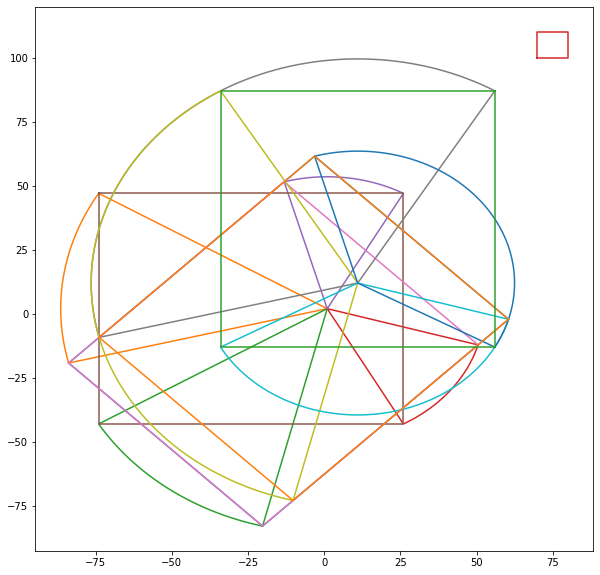

False

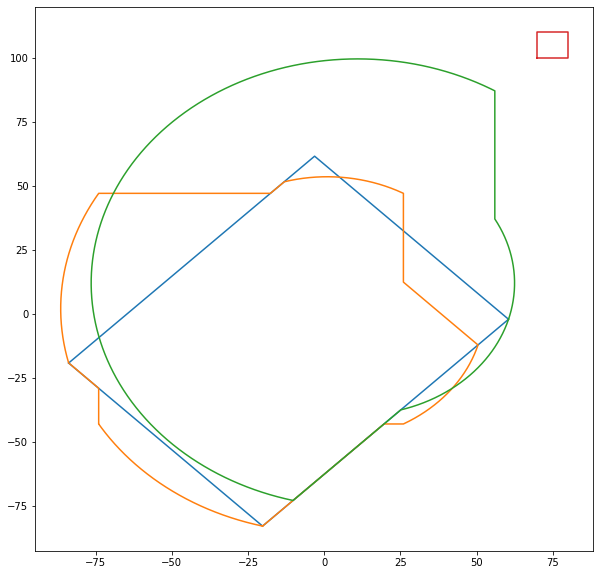

False

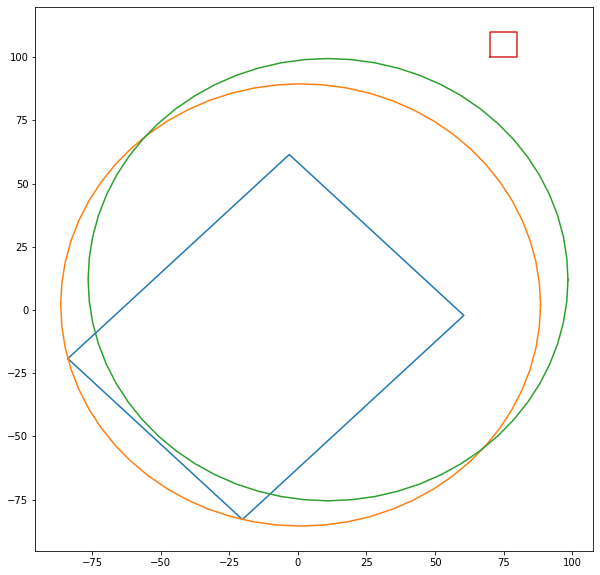

False

In [16]:
start_state = State(1,2,0)
end_state = State(11,12,270)
trajectories = getTrajectory(start_state, end_state)
trajectories.prettyPrint()

intermediate_states = simulateAction(start_state, end_state, trajectories)
for i, state in enumerate(intermediate_states):
    print("\tMoved to ",prettyTuple(state.toTuple()), " using action ", prettyTuple(trajectories.getActions()[i].toTuple()))

o = OperationalSpace([Obstacle(70,100,10,10)])
o.isCollision(trajectories, start_state, end_state, basic=False, as_union=False, verbose=True)
o.isCollision(trajectories, start_state, end_state, basic=False, as_union=True, verbose=True)
o.isCollision(trajectories, start_state, end_state, basic=True, as_union=True, verbose=True)

### 2(d). Combine the above to implement an RRT planner generating a trajectory from a speciﬁed initial state to a desired goal region. Visualize the evolution of the RRT.

In [17]:
def RRT(state_space, obstacle_space, xi, goal_space):
    # RRT Algorithm
    V = [xi] # vertices
    E = [] # edges
    E_interval = 10
    E_intermediate = {} # dict of edges at particular intervals
    hit_goal = False
    V_goal = None
    iteration_no = 0
    x_rands = []
    
    # Relative timing variables
    time_xrand = 0 # time to find x_rand
    time_closest_point = 0 # time to find closest point
    time_find_xnew = 0 # time to travel to closest point (to get x_new) and add x_new to tree
    time_final_path = 0 # time to find the final path after goal is found

    while (not hit_goal):
    #while (iteration_no < 2000):
        start_time = time.time()
        not_obstacle = False
        
        # Randomly pick a point in that isn't in an obstacle
        while (not not_obstacle):
            (x_coord_rand, y_coord_rand, theta_rand) = (random.random()*state_space.getW(), random.random()*state_space.getH(), random.random()*360)
            if (not obstacle_space.isObstacle(State(x_coord_rand, y_coord_rand, theta_rand))):
                not_obstacle = True
        x_rand = State(x_coord_rand, y_coord_rand, theta_rand)
        time_xrand += time.time() - start_time
        x_rands += [x_rand]
        
        # Get the closest point 
        start_time = time.time()
        closest_point = getClosestPoint(getDist, V, x_rand)
        time_closest_point += time.time() - start_time
        
        # Drive toward x_rand from the closest point to end up at x_new
        start_time = time.time()
        trajectories = getTrajectory(closest_point, x_rand)

        # Determine if there is a collision with an obstacle; if not, add x_new to vertices V
        if (not obstacle_space.isCollision(trajectories, closest_point, x_rand)):
            x_new = simulateAction(closest_point, x_rand, trajectories)[-1]
            V.append(x_new)
            E.append((closest_point, x_new))
            if (Polygon(np.array(goal_space[0:2]).T).intersects(x_new.toShapely())):
                if len(goal_space) > 2:
                    # also check if x_new.getTheta() is within any of the ranges specified
                    hit_goal = False
                    for theta_range in goal_space[2]:
                        theta_ = 360 + x_new.getTheta() if x_new.getTheta() < 0 else x_new.getTheta()
                        if theta_range[0] <= theta_ < theta_range[1]:
                            hit_goal = True
                            break
                else:
                    hit_goal = True
                if hit_goal:
                    V_goal = x_new
        time_find_xnew += time.time() - start_time
                
        if iteration_no % E_interval == 0:
            E_intermediate[iteration_no] = copy(E)
        iteration_no += 1
    E_intermediate[iteration_no] = copy(E)
    
    start_time = time.time()
    current_state = V_goal
    current_trajectory = [V_goal]
    while (current_state.toTuple() != xi.toTuple()):
        parent_edges = [x for x in E if x[1].toTuple() == current_state.toTuple()]
        assert(len(parent_edges) == 1)
        current_state = parent_edges[0][0]
        current_trajectory.append(current_state)
    time_final_path = time.time() - start_time
    
    print("Total time to find random points: ", time_xrand)
    print("Total time to find closest point to x_rand: ",time_closest_point)
    print("Total time to find x_new given closest point: ",time_find_xnew)
    print("Total time to find final path from tree: ",time_final_path)
        
    return current_trajectory, V, x_rands, iteration_no, E_intermediate

#### Demonstrating RRT

In [18]:
state_space = StateSpace(1000,1000)
obstacle_space = OperationalSpace([
    Obstacle(800,800,100,100),           # top right obstacle
    Obstacle(500,500,100,100),           # bottom left obstacle
    Obstacle(800,500,100,100),           # bottom right obstacle
    Obstacle(500,800,100,100)] +         # top left obstacle
    state_space.toObstacles(1))          # add state space obstacles
xi = State(100, 100, 90)
goal_space = np.array([[650,650,750,750],[650,750,750,650]])

# init plotter
plotter = Plotter(state_space=state_space, goal_space=goal_space, color_scheme=flat_land, obstacle_space=obstacle_space,
                  high_def=True)

Total time to find random points:  0.19593524932861328
Total time to find closest point to x_rand:  0.01699233055114746
Total time to find x_new given closest point:  5.157282590866089
Total time to find final path from tree:  0.0010001659393310547


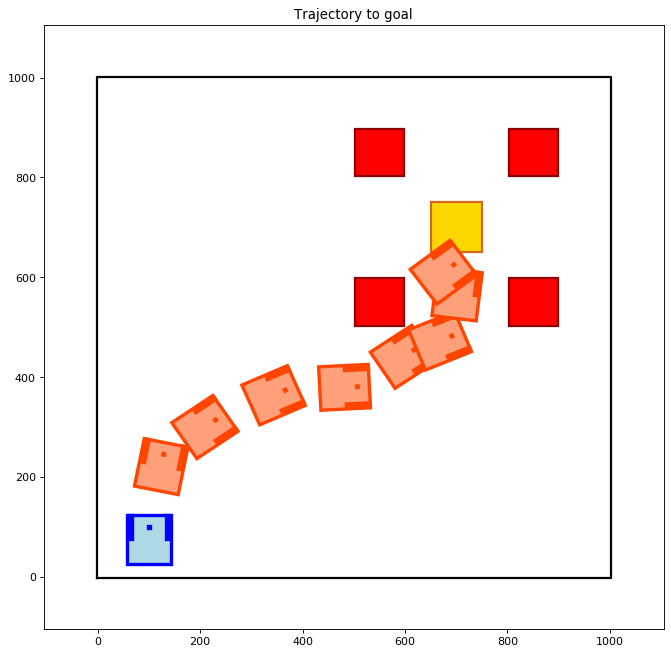

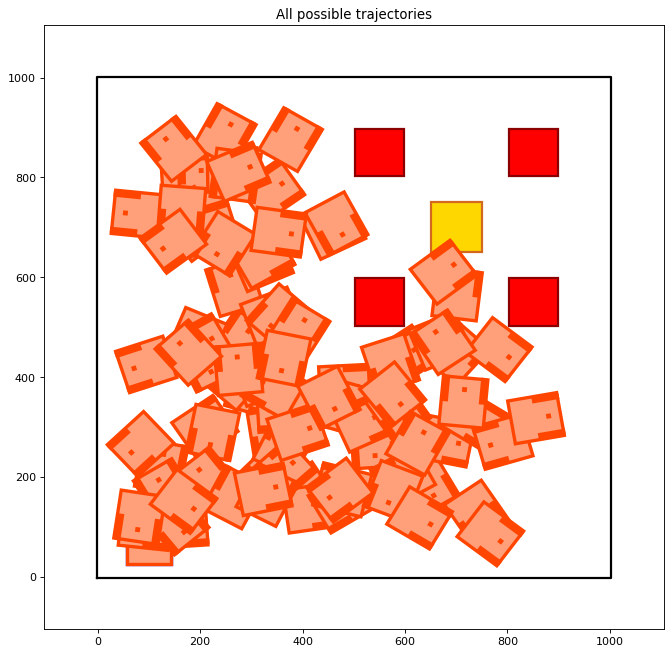

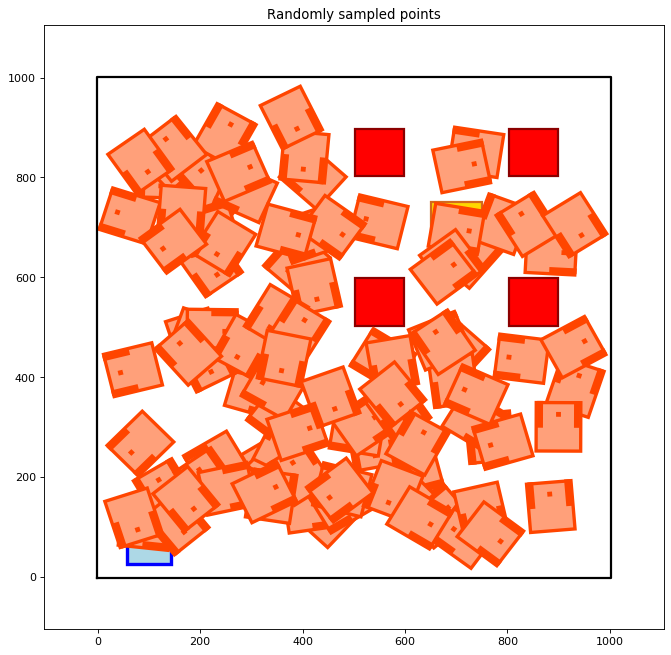

In [19]:
current_trajectory, V, x_rands, iteration_no, E_intermediate = RRT(state_space, obstacle_space, xi, goal_space)
# flip current_trajectory so that the first step is moving from start:
current_trajectory = np.array(current_trajectory)
current_trajectory = np.flip(current_trajectory, axis=0)
    
# Plot final trajectory
plotter.plot_trajectory(xi, current_trajectory[1:], title='Trajectory to goal')

# Plot tree of possible trajectories
plotter.plot_trajectory(xi, V, title='All possible trajectories')

# Plot all randomly sampled states
plotter.plot_trajectory(xi, x_rands, title='Randomly sampled points')

#### Save current_trajectory to gif

In [20]:
anim = Animator(current_trajectory, frames_per_transistion=10)

In [21]:
anim.gatherControllerInputs()
anim.gatherIntermediateStates()
anim.trajectoryGif(gif_name='RRT_trajectory', state_space=state_space, goal_space=goal_space, color_scheme=flat_land, 
                   obstacle_space=obstacle_space, high_def=True)

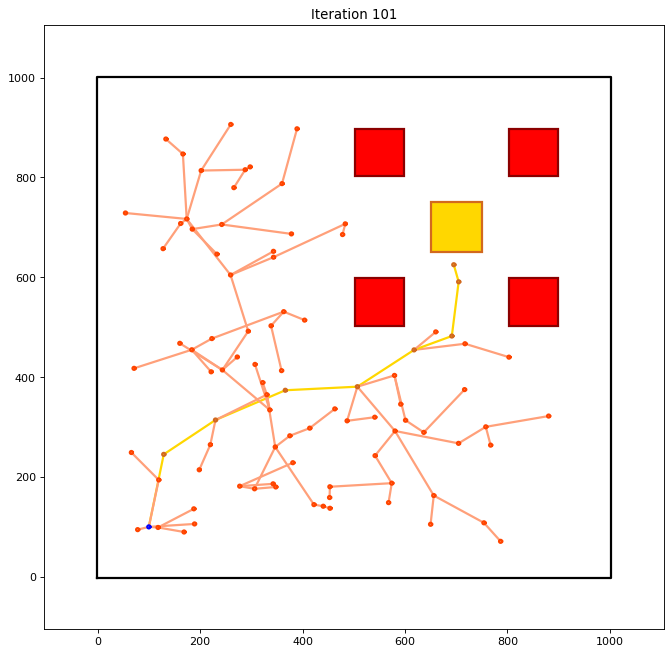

In [22]:
anim.connectionsGif(e_intermediate=E_intermediate, gif_name='RRT_connections', state_space=state_space, goal_space=goal_space, 
                    color_scheme=flat_land, obstacle_space=obstacle_space, high_def=True)

## 3 Evaluation and Extensions

### 3(a). Run some examples that demonstrate the performance (in terms of computational eﬃciency, trajectory eﬃciency, and obstacle avoidance) of your planner as your robot tries to achieve various goals (such as head-in parking and parallel parking between other such parked vehicles). Clearly describe the experiments that were run, the data that was gathered, and the process by which you use that data to characterize the performance of your planner. Include ﬁgures; you may also refer to animations uploaded to your git repo.

Conclusions from the following examples are made in the lab report.

#### Bridges:

In [23]:
# Create a narrow lane (i.e. a bridge, tunnel, or one way road) that the robot has to navigate through to reach the goal state

state_space3 = StateSpace(1000,1000)

# Create obstacles that represent a bridge
obstacle_space3 = OperationalSpace([
    Obstacle(0,200,445,500),           
    Obstacle(555,200,445,500)] +       
    state_space3.toObstacles(1))          # add state space obstacles
xi3 = State(100, 100, 90)
goal_space3 = np.array([[800,800,900,900],[800,900,900,800]])

# init plotter
plotter3 = Plotter(state_space=state_space3, goal_space=goal_space3, color_scheme=parking_lot, obstacle_space=obstacle_space3,
                  high_def=True)


Total time to find random points:  0.5768909454345703
Total time to find closest point to x_rand:  0.008020162582397461
Total time to find x_new given closest point:  4.752299547195435
Total time to find final path from tree:  0.0


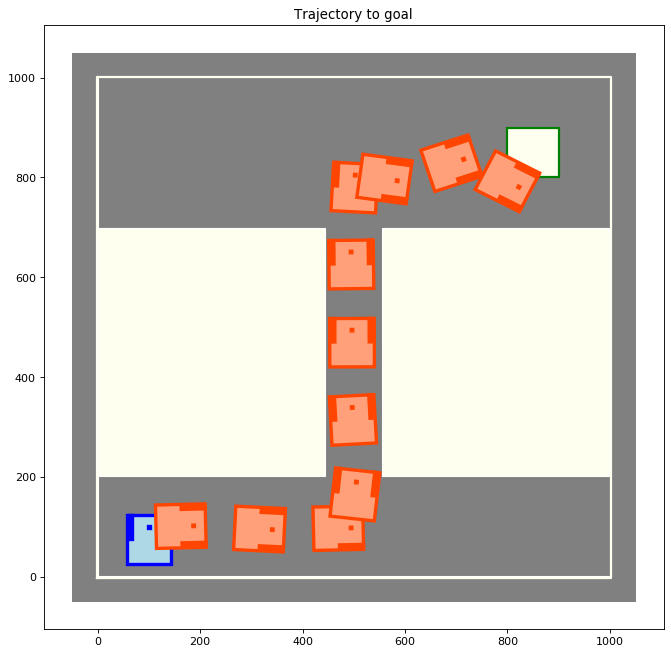

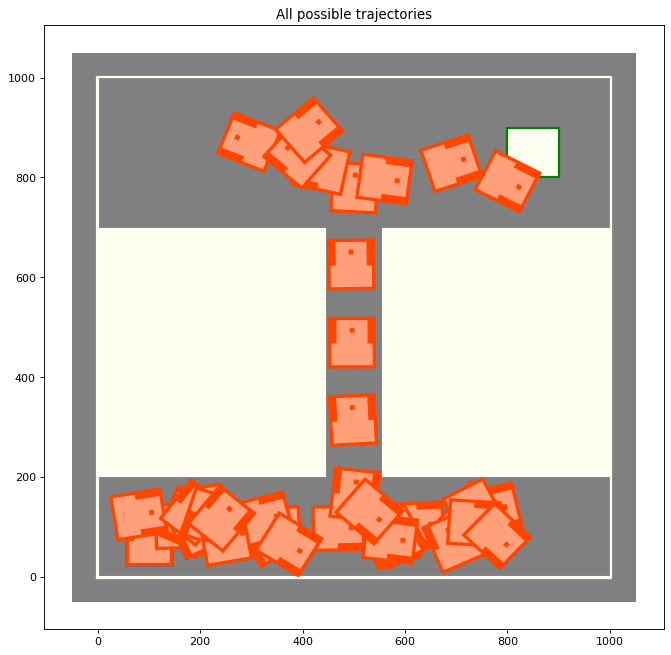

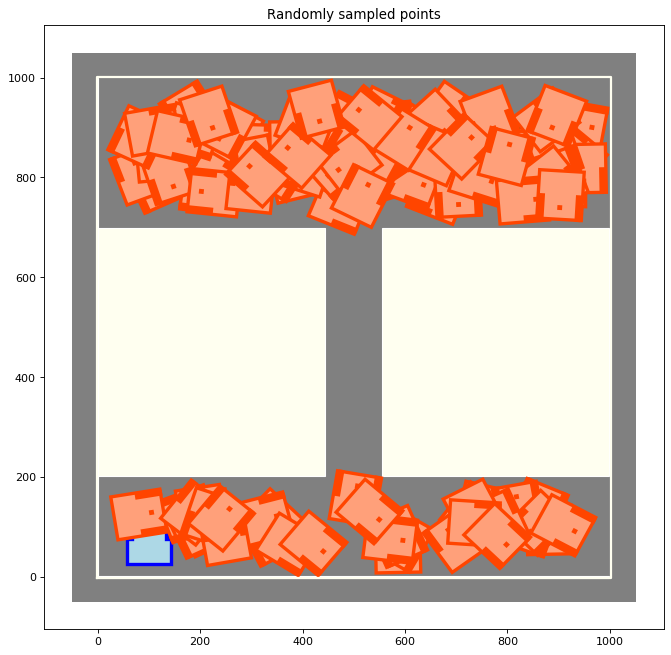

In [24]:
current_trajectory3, V3, x_rands3, iteration_no3, E_intermediate3 = RRT(state_space3, obstacle_space3, xi3, goal_space3)
# flip current_trajectory so that the first step is moving from start:
current_trajectory3 = np.array(current_trajectory3)
current_trajectory3 = np.flip(current_trajectory3, axis=0)
    
# Plot final trajectory
plotter3.plot_trajectory(xi3, current_trajectory3[1:], title='Trajectory to goal')

# Plot tree of possible trajectories
plotter3.plot_trajectory(xi3, V3, title='All possible trajectories')

# Plot all randomly sampled states
plotter3.plot_trajectory(xi3, x_rands3, title='Randomly sampled points')

In [25]:
anim = Animator(current_trajectory3, frames_per_transistion=10)
anim.gatherControllerInputs()
anim.gatherIntermediateStates()
anim.trajectoryGif(gif_name='Bridge_RRT_trajectory', state_space=state_space3, goal_space=goal_space3, color_scheme=parking_lot, 
                   obstacle_space=obstacle_space3, high_def=True)

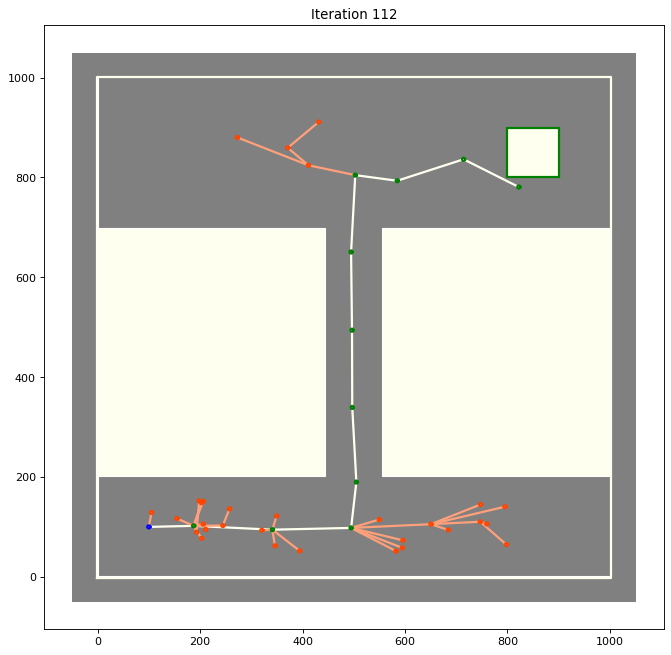

In [26]:
anim.connectionsGif(e_intermediate=E_intermediate3, gif_name='Bridge_RRT_connections', state_space=state_space3, goal_space=goal_space3, 
                    color_scheme=parking_lot, obstacle_space=obstacle_space3, high_def=True)

#### Parallel parking:

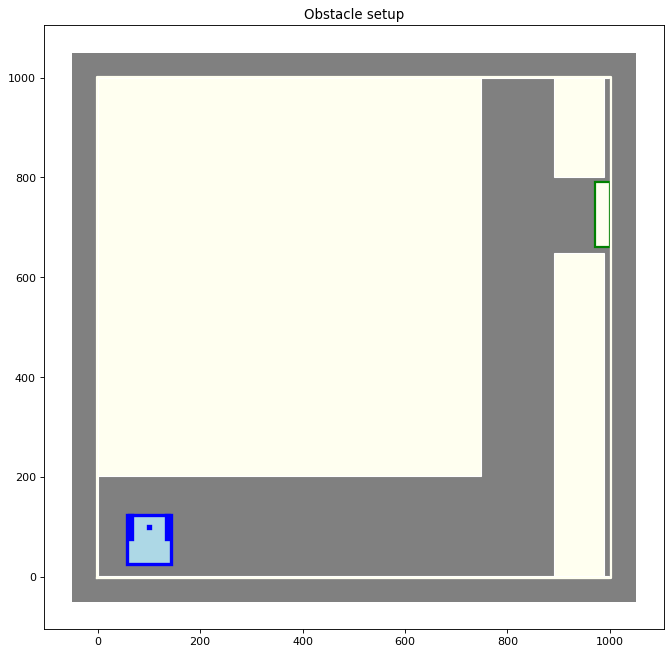

In [27]:
cs = parking_lot

state_space_ll = StateSpace(1000,1000)
obstacle_list_ll = [
    Obstacle(0,200,750,800),           # bottom left obstacle
    Obstacle(890, 800, 100, 200),
    Obstacle(890, 0, 100, 650)
]
obstacle_space_ll = OperationalSpace(obstacle_list_ll + state_space_ll.toObstacles(1))
xi_ll = State(100, 100, 90)
goal_space_ll = [[970,970,1000,1000],[660,790,790,660],[[82.5, 97.5],[262.5,277.5]]]

# init plotter
plotter_ll = Plotter(state_space=state_space_ll, goal_space=goal_space_ll, color_scheme=cs, 
                     obstacle_space=obstacle_space_ll, high_def=True, obstacle_lim=len(obstacle_space_ll.getObstacles()))
plotter_ll.plot_trajectory(xi_ll, [], title='Obstacle setup')

TopologyException: Input geom 1 is invalid: Self-intersection at or near point 522.04898730408081 95.604671679048465 at 522.04898730408081 95.604671679048465


Total time to find random points:  9.423774003982544
Total time to find closest point to x_rand:  1.1652660369873047
Total time to find x_new given closest point:  87.21498537063599
Total time to find final path from tree:  0.0050013065338134766


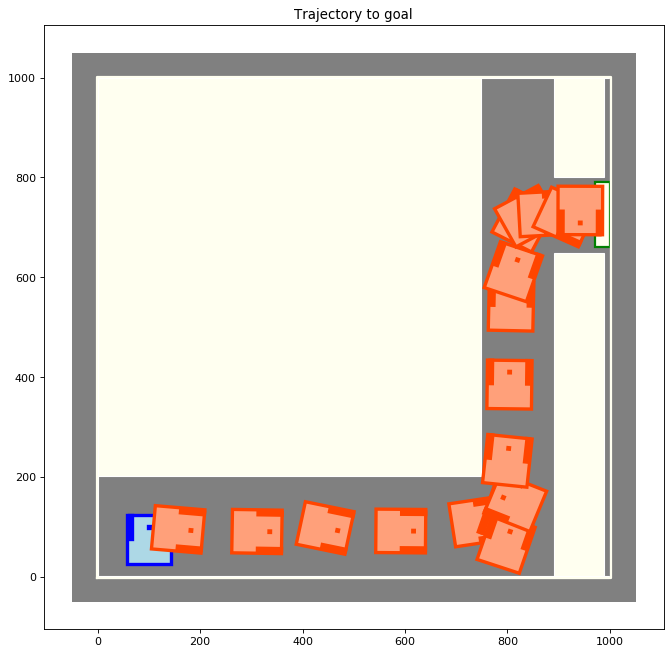

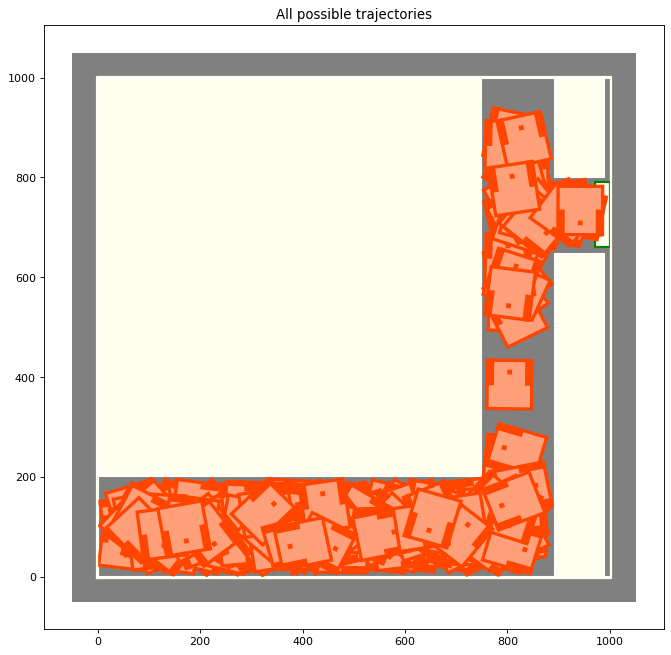

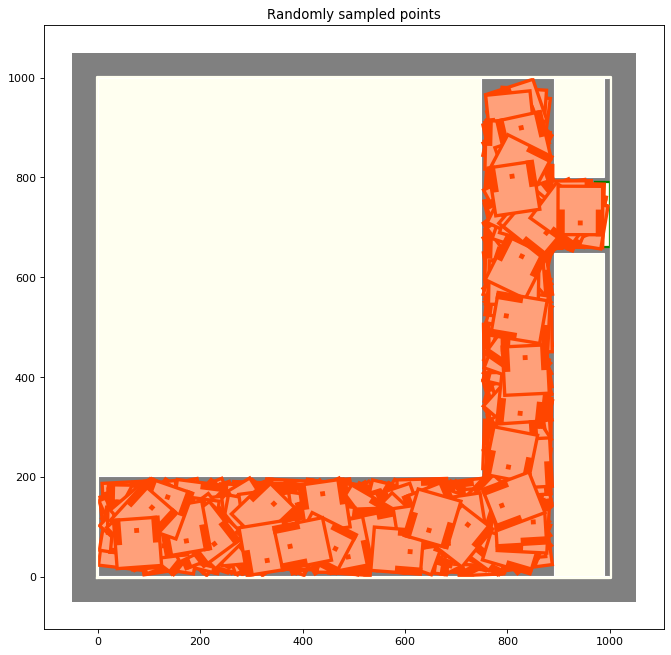

In [28]:
current_trajectory_ll, V_ll, x_rands_ll, iteration_no_ll, E_intermediate_ll = RRT(state_space_ll, obstacle_space_ll, 
                                                                                  xi_ll, goal_space_ll)
# flip current_trajectory so that the first step is moving from start:
current_trajectory_ll = np.array(current_trajectory_ll)
current_trajectory_ll = np.flip(current_trajectory_ll, axis=0)
    
# Plot final trajectory
plotter_ll.plot_trajectory(xi_ll, current_trajectory_ll[1:], title='Trajectory to goal')

# Plot tree of possible trajectories
plotter_ll.plot_trajectory(xi_ll, V_ll, title='All possible trajectories')

# Plot all randomly sampled states
plotter_ll.plot_trajectory(xi_ll, x_rands_ll, title='Randomly sampled points')

In [29]:
anim = Animator(current_trajectory_ll, frames_per_transistion=10, obstacle_lim=len(obstacle_space_ll.getObstacles()))
anim.gatherControllerInputs()
anim.gatherIntermediateStates()
anim.trajectoryGif(gif_name='parallel_park_RRT_trajectory', state_space=state_space_ll, goal_space=goal_space_ll, 
                   color_scheme=cs, obstacle_space=obstacle_space_ll, high_def=True)

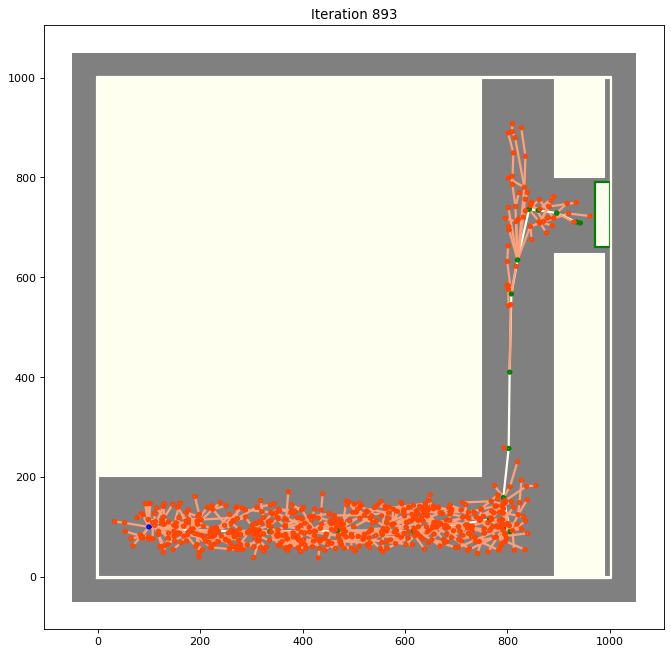

In [30]:
anim.connectionsGif(e_intermediate=E_intermediate_ll, gif_name='parallel_park_RRT_connections', state_space=state_space_ll, goal_space=goal_space_ll, 
                    color_scheme=cs, obstacle_space=obstacle_space_ll, high_def=True)

#### Maze:

In [32]:
# Create a maze that the robot has to navigate through to reach a goal state

border_width = 10

state_space2 = StateSpace(4600,3400)
xi2 = State(200, 2300, 0)
goal_space2 = np.array([[3850,3850,4350,4350],[3250,2550,2550,3250]])
obstacles2 = [Obstacle(200,2600,border_width,600),
             Obstacle(200,3200,3600,border_width),
             Obstacle(4400,200,border_width,3000),
             Obstacle(200,200,4200,border_width),
             Obstacle(200,200,border_width,1800),
             Obstacle(3800, 1400, border_width, 1800),
             Obstacle(3200, 1400, 600, border_width),
             Obstacle(3200, 1400, border_width, 1200),
             Obstacle(800, 2600, 2400, border_width),
             Obstacle(2000, 2000, border_width, 600),
             Obstacle(800, 1400, border_width, 600),
             Obstacle(800, 2000, 600, border_width),
             Obstacle(1400, 1400, border_width, 600),
             Obstacle(1400, 1400, 1200, border_width),
             Obstacle(2600, 800, border_width, 1200),
             Obstacle(2600, 800, 1200, border_width),
             Obstacle(3200, 200, border_width, 600),
             Obstacle(800, 800, 1200, border_width)
            ]
obstacle_space2 = OperationalSpace(obstacles2 + state_space2.toObstacles())

# init plotter
plotter2 = Plotter(state_space=state_space2, goal_space=goal_space2, color_scheme=flat_land, obstacle_space=obstacle_space2,
                  high_def=True, obstacle_lim=len(obstacles2))

Total time to find random points:  4.287710666656494
Total time to find closest point to x_rand:  0.6441426277160645
Total time to find x_new given closest point:  15.009626388549805
Total time to find final path from tree:  0.008992671966552734


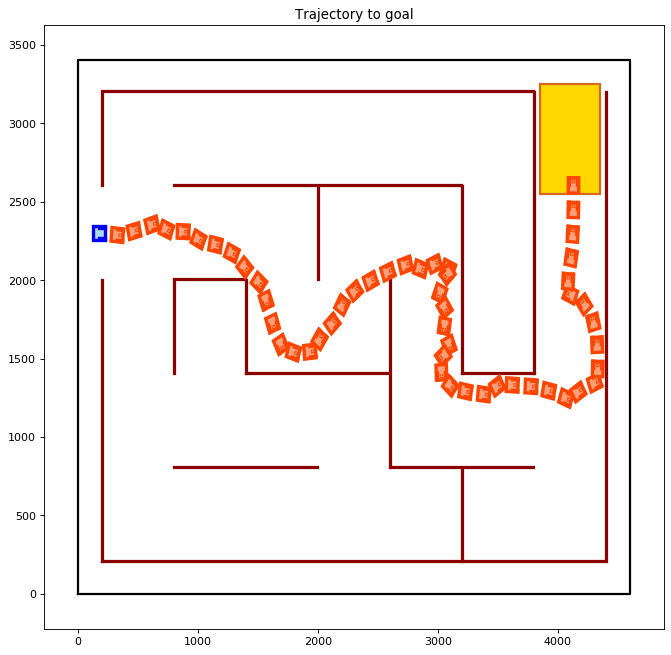

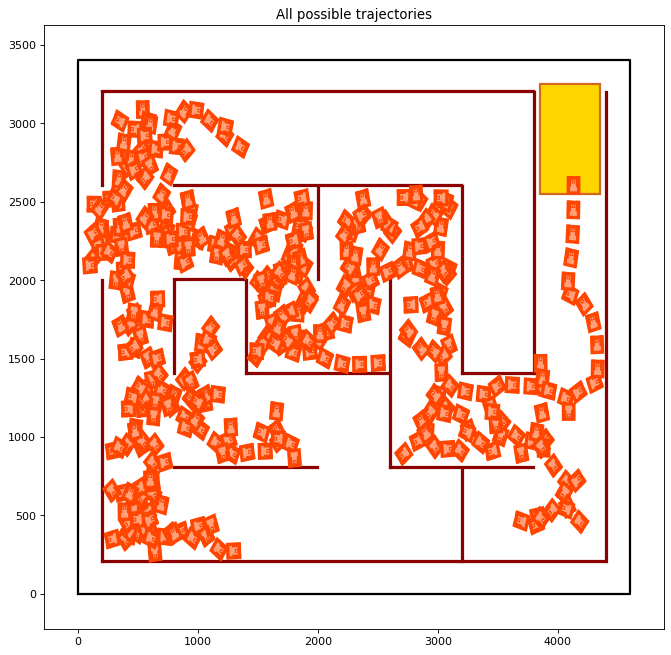

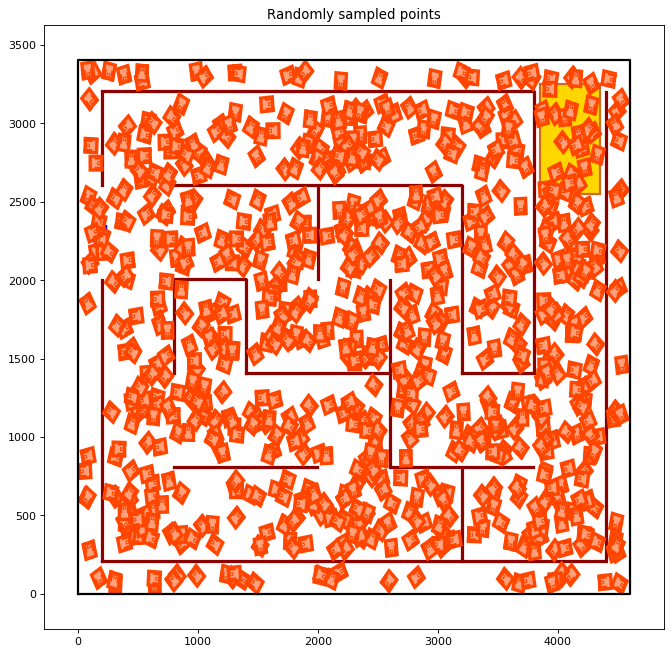

In [33]:
current_trajectory2, V2, x_rands2, iteration_no2, E_intermediate2 = RRT(state_space2, obstacle_space2, xi2, goal_space2)
# flip current_trajectory so that the first step is moving from start:
current_trajectory2 = np.array(current_trajectory2)
current_trajectory2 = np.flip(current_trajectory2, axis=0)
    
# Plot final trajectory
plotter2.plot_trajectory(xi2, current_trajectory2[1:], title='Trajectory to goal')

# Plot tree of possible trajectories
plotter2.plot_trajectory(xi2, V2, title='All possible trajectories')

# Plot all randomly sampled states
plotter2.plot_trajectory(xi2, x_rands2, title='Randomly sampled points')

In [34]:
anim = Animator(current_trajectory2, frames_per_transistion=3, obstacle_lim=len(obstacles2))
anim.gatherControllerInputs()
anim.gatherIntermediateStates()
anim.trajectoryGif(gif_name='maze_RRT_trajectory', state_space=state_space2, goal_space=goal_space2, color_scheme=flat_land, 
                   obstacle_space=obstacle_space2, high_def=True)

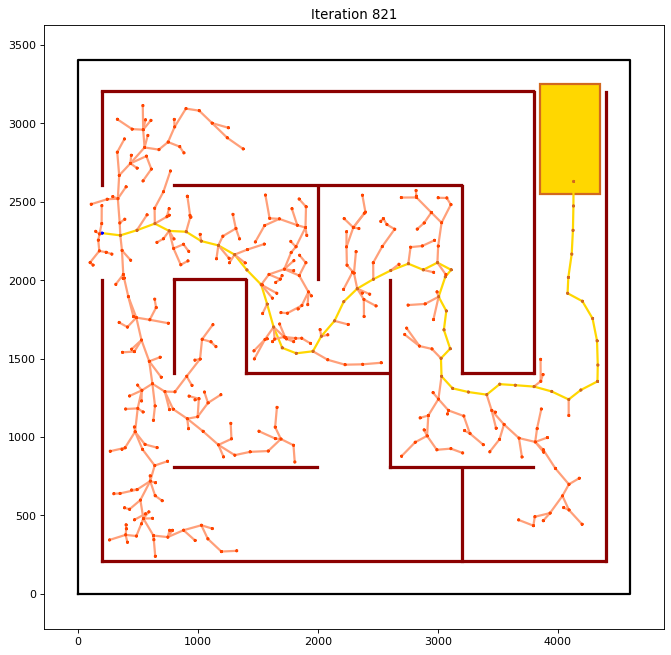

In [35]:
anim.connectionsGif(e_intermediate=E_intermediate2, gif_name='maze_RRT_connections', state_space=state_space2, goal_space=goal_space2, 
                    color_scheme=flat_land, obstacle_space=obstacle_space2, high_def=True)

### 3(b). How much relative computational cost is associated with the various operations of the RRT planner?

The computational cost of the time to find random points, time to find the closest point to x_rand, the time to find x_new given closest point, and the time to find the final path from the tree are computed in each simulation.

### 3(c). Improve on your planner using the RRT* algorithm, and compare to your original RRT planner using the above metrics.

In [36]:
def isFeasible(trajectory, xi, xt, verbose=False, basic=False):
    # check that trajectory encounters no obstacles
    if (obstacle_space.isCollision(trajectory, xi, xt, verbose=verbose, basic=basic)):
        return False
    simulated_end_state = simulateAction(xi, xt, trajectory)[-1]
    
    # check that trajectory is achievable (to end state) 
    expected_tuple = xt.toTuple()
    obtained_tuple = simulated_end_state.toTuple()
    for i in range(len(expected_tuple)):
        # check that each individual index is approximately the same
        if round(expected_tuple[i], 4) != round(obtained_tuple[i], 4):
            return False
    return True

def RRT_star(state_space, obstacle_space, xi, goal_space, iterations=200, E_interval=10, basic=False):
    # RRT* Algorithm
    xi.setCost(0)
    V = [xi]
    E = []
    E_intermediate = {} # dict of edges at particular intervals
    x_rands = []
    
    # Relative timing variables
    time_xrand = 0 # time to find x_rand
    time_closest_point = 0 # time to find closest point
    time_find_xnew = 0 # time to travel to closest point (to get x_new) and add x_new to tree
    time_final_path = 0 # time to find the final path after goal is found
    time_knn = 0 # time to find k nearest neighbors from x_new (for better parent/child path)
    time_best_parent = 0 # time to find best parent for x_new from neighbors
    time_xnew_as_parent = 0 # time to update all neighbors that have lower cost with x_new as parent
    time_best_goal_vertex = 0 # time to find vertex within goal with lowest cost to the start point

    iteration_no = 0
    with tqdm_notebook(total=iterations) as pbar:
        while iteration_no < iterations:
            start_time = time.time()
            not_obstacle = False
            while (not not_obstacle):
                (x_coord_rand, y_coord_rand, theta_rand) = (random.random()*state_space.getW(), random.random()*state_space.getH(), random.random()*360)
                if (not obstacle_space.isObstacle(State(x_coord_rand, y_coord_rand, theta_rand))):
                    not_obstacle = True
            x_rand = State(x_coord_rand, y_coord_rand, theta_rand)
            time_xrand += time.time() - start_time
            x_rands += [x_rand]

            start_time = time.time()
            x_nearest = getClosestPoint(getDist, V, x_rand)
            time_closest_point += time.time() - start_time

            start_time = time.time()
            trajectories = getTrajectory(x_nearest, x_rand)

            if (not obstacle_space.isCollision(trajectories, x_nearest, x_rand, basic=basic)):
                x_new = simulateAction(x_nearest, x_rand, trajectories)[-1]
                time_find_xnew += time.time() - start_time

                start_time = time.time()
                # Find k nearest points (L2 norm)
                k = min(len(V)-1, 200)
                X_near = sorted(V, key=lambda x: getDist(x_new, x))[-k:]
                #X_near = sorted(V, key=lambda x: math.sqrt((x.getX()-x_new.getX())**2+(x.getY()-x_new.getY())**2))[-k:]
                time_knn += time.time() - start_time

                start_time = time.time()
                x_min = x_nearest
                c_min = x_nearest.getCost() + getDist(x_nearest, x_new) # cost of current nearest node

                # find best parent for x_new
                for x_near in X_near: # iterate over k nearest neighbors
                    if isFeasible(getTrajectory(x_near, x_new), x_near, x_new, basic=basic): # if collision free
                        c_current = x_near.getCost() + getDist(x_near, x_new) # cost of neighbor
                        if (c_current < c_min): # update parent to one with best overall cost
                            x_min = x_near
                            c_min = c_current
                time_best_parent += time.time() - start_time

                # add x_new to tree
                x_new.setCost(c_min)
                E.append((x_min, x_new))
                V.append(x_new)

                start_time = time.time()
                # Rewire tree (see if x_new is a better parent for other x)
                for x_near in X_near:
                    if isFeasible(getTrajectory(x_new, x_near), x_new, x_near):
                        current_cost = x_new.getCost() + getDist(x_new, x_near) # possible better cost for x_near using x_new as parent
                        if (current_cost < x_near.getCost()):
                            # find old parent of x_near and change it to x_new
                            for i, e in enumerate(E):
                                if (e[1].toTuple() == x_near.toTuple()):
                                    E[i] = (x_new, x_near)
                                    x_near.setCost(current_cost)
                time_xnew_as_parent += time.time() - start_time
                
                if iteration_no % E_interval == 0:
                    E_intermediate[iteration_no] = deepcopy(E)
                    
                iteration_no += 1
                pbar.update(1)

    start_time = time.time()
    
    # find all tree vertices within goal space
    goal_space_polygon = Polygon(np.array(goal_space[0:2]).T)
    goal_vertices = []
    for v in V:
        if (goal_space_polygon.intersects(v.toShapely())):
            goal_vertices.append(v)

    # find vertex in goal space with *lowest* cost (as opposed to just any goal space path)
    best_goal_vertex = goal_vertices[0]
    best_goal_cost = best_goal_vertex.getCost()
    for v in goal_vertices[1:]:
        if (v.getCost() < best_goal_cost):
            best_goal_vertex = v
            best_goal_cost = v.getCost()
            
    time_best_goal_vertex = time.time() - start_time
            
    # find trajectory from best-path goal vertex backwards (to start point)
    start_time = time.time()
    current_state = best_goal_vertex
    current_trajectory = [best_goal_vertex]
    while (current_state.toTuple() != xi.toTuple()):
        parent_edges = [x for x in E if x[1].toTuple() == current_state.toTuple()]
        assert(len(parent_edges) == 1)
        current_state = parent_edges[0][0]
        current_trajectory.append(current_state)
    time_final_path = time.time() - start_time
        
    print("Total time to find random points: ", time_xrand)
    print("Total time to find closest point to x_rand: ",time_closest_point)
    print("Total time to find x_new given closest point: ",time_find_xnew)
    print("Total time to find k nearest neighbors to x_new: ",time_knn)
    print("Total time to find best parent for x_new: ",time_best_parent)
    print("Total time to update all neighbors where x_new is a better parent: ",time_xnew_as_parent)
    print("Total time to find point within goal space with lowest cost: ", time_best_goal_vertex)
    print("Total time to find final path from tree: ",time_final_path)
            
    return current_trajectory, V, x_rands, iteration_no, E_intermediate, best_goal_vertex

In [37]:
state_space = StateSpace(1000,1000)
obstacle_space = OperationalSpace([
    Obstacle(800,800,100,100),           # top right obstacle
    Obstacle(500,500,100,100),           # bottom left obstacle
    Obstacle(800,500,100,100),           # bottom right obstacle
    Obstacle(500,800,100,100)] +         # top left obstacle
    state_space.toObstacles(1))          # add state space obstacles
xi = State(100, 100, 90)
goal_space = np.array([[650,650,750,750],[650,750,750,650]])

# init plotter
plotter = Plotter(state_space=state_space, goal_space=goal_space, color_scheme=flat_land, obstacle_space=obstacle_space,
                  high_def=True)

##### Basic collider


Total time to find random points:  0.237013578414917
Total time to find closest point to x_rand:  0.031049489974975586
Total time to find x_new given closest point:  0.10009074211120605
Total time to find k nearest neighbors to x_new:  0.02221226692199707
Total time to find best parent for x_new:  3.6162071228027344
Total time to update all neighbors where x_new is a better parent:  167.5617072582245
Total time to find point within goal space with lowest cost:  0.00600123405456543
Total time to find final path from tree:  0.0010099411010742188


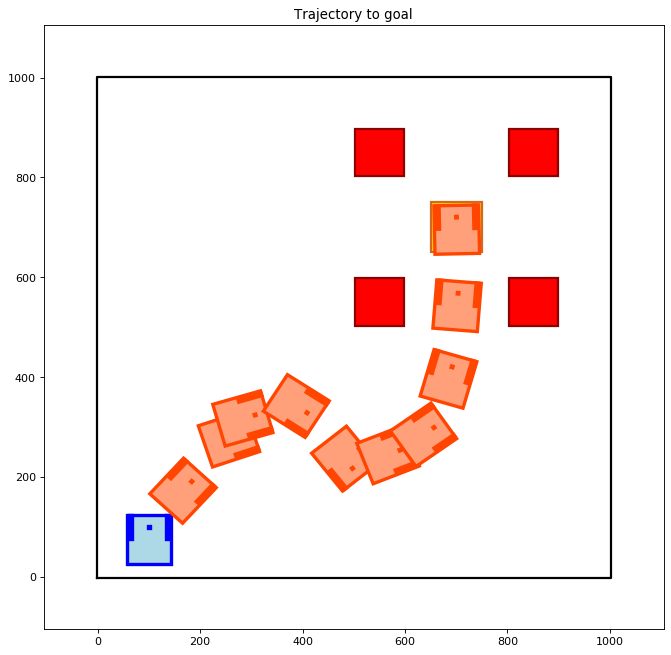

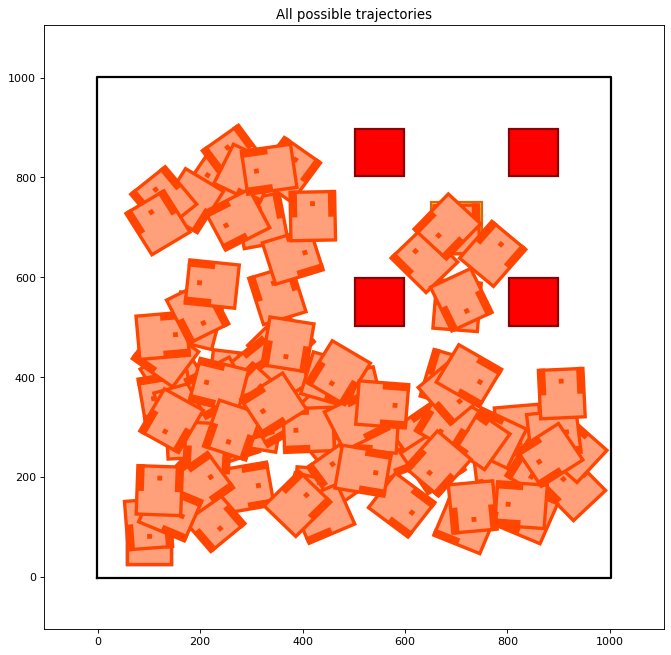

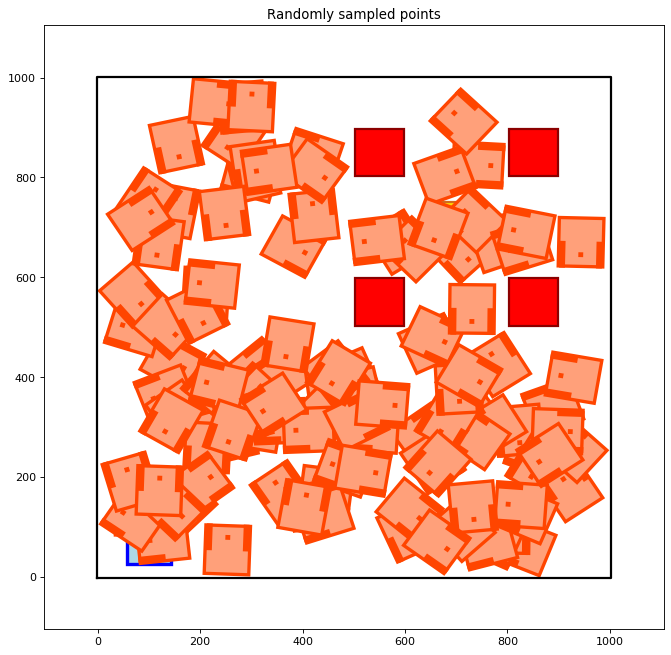

In [41]:
current_trajectory_star, V_star, x_rands_star, iteration_no_star, \
    E_intermediate_star, best_goal_vertex_star = RRT_star(state_space, obstacle_space, xi, goal_space, iterations=100,
                                                          E_interval=5, basic=True)

# flip current_trajectory so that the first step is moving from start:
current_trajectory_star = np.array(current_trajectory_star)
current_trajectory_star = np.flip(current_trajectory_star, axis=0)

# Plot final trajectory
plotter.plot_trajectory(xi, current_trajectory_star[1:], title='Trajectory to goal')

# Plot tree of possible trajectories
plotter.plot_trajectory(xi, V_star, title='All possible trajectories')

# Plot all randomly sampled states
plotter.plot_trajectory(xi, x_rands_star, title='Randomly sampled points')

#### Save current_trajectory to gif

In [42]:
anim = Animator(current_trajectory_star, frames_per_transistion=10)

In [43]:
anim.gatherControllerInputs()
anim.gatherIntermediateStates()
anim.trajectoryGif(gif_name='RRT_star_trajectory', state_space=state_space, goal_space=goal_space, color_scheme=flat_land, 
                   obstacle_space=obstacle_space, high_def=True)

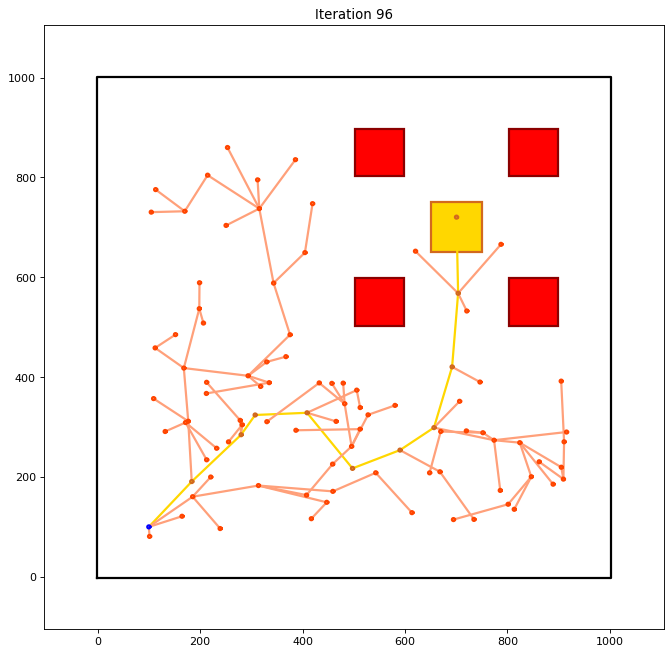

In [44]:
anim.connectionsGif(e_intermediate=E_intermediate_star, gif_name='RRT_star_connections', state_space=state_space, 
                    goal_space=goal_space, color_scheme=flat_land, obstacle_space=obstacle_space, 
                    goal_vert=best_goal_vertex_star, high_def=True)

##### Complex collider

TopologyException: no outgoing dirEdge found at 144.99999999999997 24.999999999999986



Total time to find random points:  0.2501034736633301
Total time to find closest point to x_rand:  0.024994611740112305
Total time to find x_new given closest point:  4.003367185592651
Total time to find k nearest neighbors to x_new:  0.0230255126953125
Total time to find best parent for x_new:  184.35443329811096
Total time to update all neighbors where x_new is a better parent:  180.55570793151855
Total time to find point within goal space with lowest cost:  0.0070116519927978516
Total time to find final path from tree:  0.0


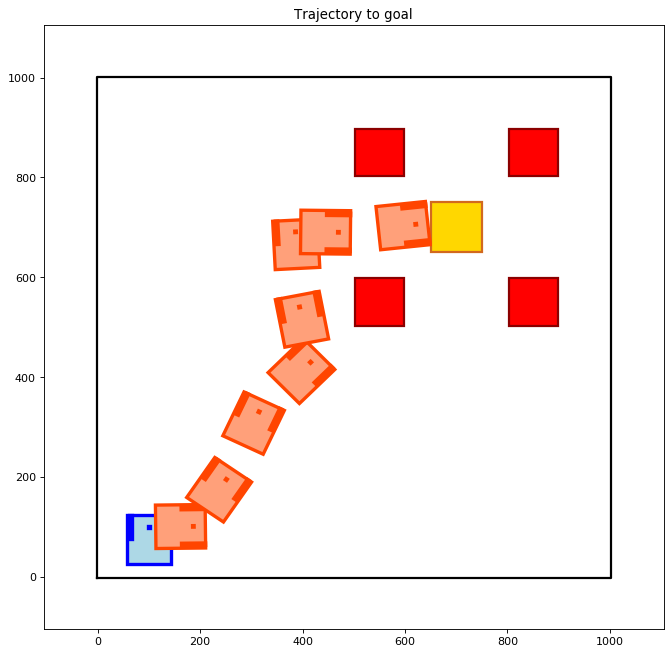

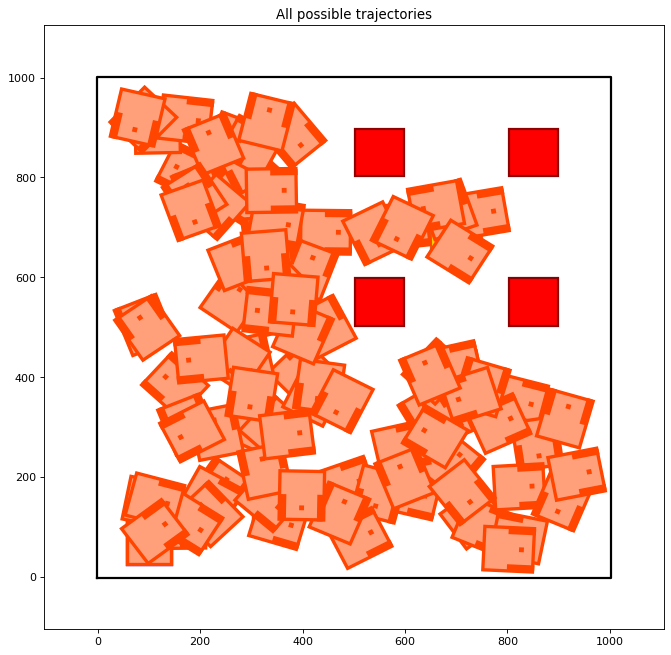

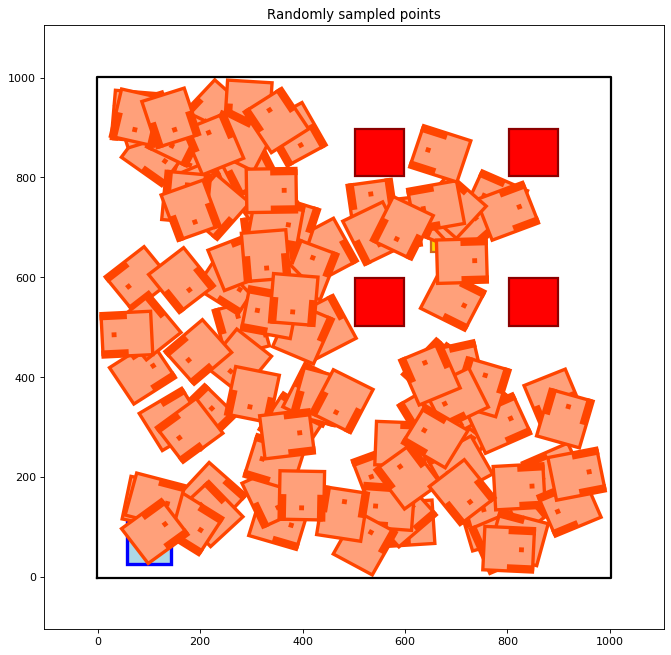

In [45]:
current_trajectory_star, V_star, x_rands_star, iteration_no_star, \
    E_intermediate_star, best_goal_vertex_star = RRT_star(state_space, obstacle_space, xi, goal_space, iterations=100,
                                                          E_interval=5, basic=False)

# flip current_trajectory so that the first step is moving from start:
current_trajectory_star = np.array(current_trajectory_star)
current_trajectory_star = np.flip(current_trajectory_star, axis=0)

# Plot final trajectory
plotter.plot_trajectory(xi, current_trajectory_star[1:], title='Trajectory to goal')

# Plot tree of possible trajectories
plotter.plot_trajectory(xi, V_star, title='All possible trajectories')

# Plot all randomly sampled states
plotter.plot_trajectory(xi, x_rands_star, title='Randomly sampled points')

#### Save current_trajectory to gif

In [46]:
anim = Animator(current_trajectory_star, frames_per_transistion=10)

In [47]:
anim.gatherControllerInputs()
anim.gatherIntermediateStates()
anim.trajectoryGif(gif_name='RRT_star_trajectory', state_space=state_space, goal_space=goal_space, color_scheme=flat_land, 
                   obstacle_space=obstacle_space, high_def=True)

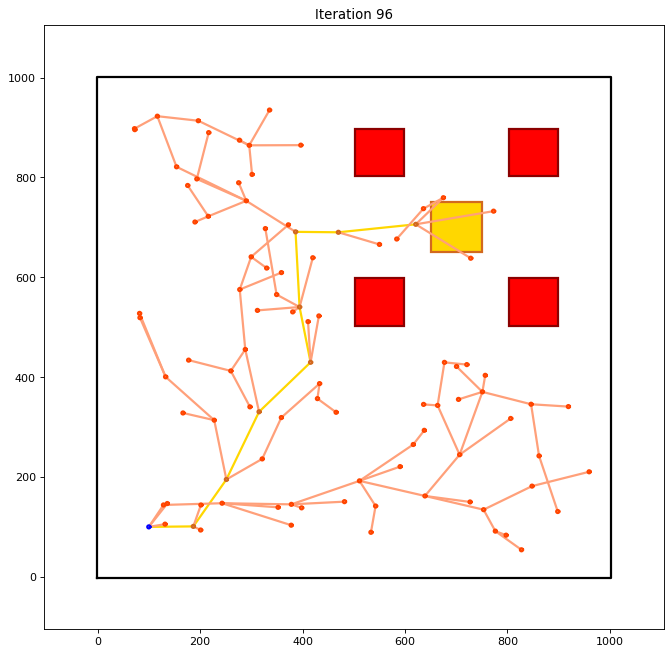

In [48]:
anim.connectionsGif(e_intermediate=E_intermediate_star, gif_name='RRT_star_connections', state_space=state_space, 
                    goal_space=goal_space, color_scheme=flat_land, obstacle_space=obstacle_space, 
                    goal_vert=best_goal_vertex_star, high_def=True)

### 3(d). Qualitatively describe some conclusions about the eﬀectiveness of your planner for potential tasks your robot may encounter. For example, what happens to your planner in the presence of process noise, i.e. a stochastic system model? How might you modify your algorithm to better handle noise?

Conclusions are made in the lab report. 